# Importing libraries and dataset

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data


In [ ]:
mnist = input_data.read_data_sets('MNIST_data/')

In [ ]:
plt.imshow(mnist.train.images[2].reshape(28,28),cmap= 'Greys')

# Creating the generator and discriminator functions

In [ ]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        #Leaky ReLU
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
        
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        #Return values for loss function
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits
        
        

In [ ]:
#Reseting current graph
tf.reset_default_graph()

In [ ]:
#Placeholders for real images and noise
real = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape = [None, 100]) #100 random points for noise

In [ ]:
G = generator(z) #Output generated images
#Making 2 descriminator: first on the real images to understand the dataset; Second for acting on generator
D_output_real, D_logits_real = discriminator(real)
#Reuse = True uses the previously trained 'des' descriminator for genrated images
D_output_fake, D_logits_fake = discriminator(G,reuse=True) 

In [ ]:
#Losses
def loss_function(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [ ]:
#0.9 is to smoothing 
#Ones like detects the shape of the tensor automatically
D_real_loss = loss_function(D_logits_real,tf.ones_like(D_logits_real)*0.9) #True for all the images in the real dataset
D_fake_loss = loss_function(D_logits_fake,tf.zeros_like(D_logits_fake))#False for all the images in the generated dataset


In [ ]:
D_loss = D_real_loss+D_fake_loss #Final loss to minimize

In [ ]:
#Descriminator must return p->1 for the generated image
G_loss = loss_function(D_logits_fake,tf.ones_like(D_logits_fake))

In [ ]:
lr = 0.001
tvars = tf.trainable_variables() #Gets all the variables from the network
d_vars = [var for var in tvars if 'dis' in var.name] 
g_vars = [var for var in tvars if 'gen' in var.name]

D_trainer = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=g_vars)

In [ ]:
#Training session
batch_size = 100
epochs = 2000
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
samples = [] #Example of produced images

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches = mnist.train.num_examples// batch_size
        for i in range(num_batches):
            #Creating batch of real images
            batch = mnist.train.next_batch(batch_size)
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images*2-1 
            #Creating noise
            batch_z = np.random.uniform(-1,1,size=(batch_size,100)) #For tanh function
            #Training the model
            _  = sess.run(D_trainer, feed_dict = {real: batch_images,z:batch_z})
            _  = sess.run(G_trainer,feed_dict={z:batch_z})
            
        print("ON EPOCH {}".format(epoch))
        #Extracting a sample form the traning epoch
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        samples.append(gen_sample)
        #Saving the model
        saver.save(sess,save_path="./model/gan_model")

# Testing the model

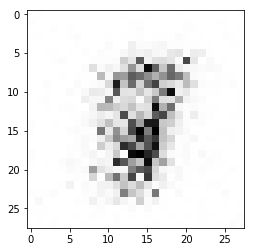

In [120]:
#After first 10 epochs
plt.imshow(samples[10].reshape(28,28),cmap= 'Greys')

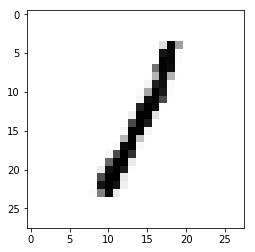

In [121]:
#After 490+ epochs
plt.imshow(samples[1990].reshape(28,28),cmap= 'Greys')

In [ ]:
saver = tf.train.Saver(var_list=g_vars)
new_samples = []
with tf.Session() as sess:
    #Restoring the saved model
    saver.restore(sess,"./model/gan_model")
    #Generating 100 random samples
    for x in range(200):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        new_samples.append(gen_sample)

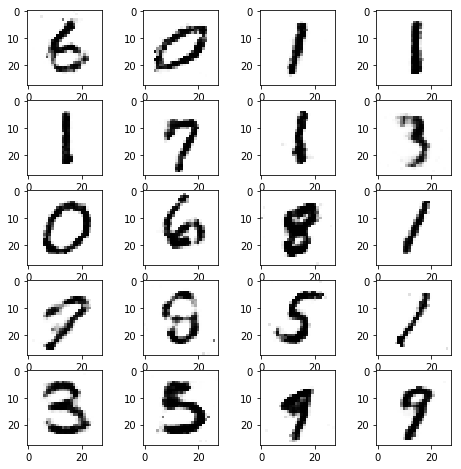

In [150]:
#Creating graph
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for l in range(1, columns*rows +1):
    #Selecting a random index
    ind = int(np.random.randint(low= 0,high =200))
    fig.add_subplot(rows, columns, l)
    #Adding the figure to graph
    plt.imshow(new_samples[ind].reshape(28,28),cmap= 'Greys')
#Showing the graph
plt.show()